# oracle_ptn_1
Establish baseline oracle performance

In [1]:
%load_ext autoreload
%autoreload 2
    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.simple_datasets.ORACLE.episodic_dataset_accessor import get_episodic_dataloaders
from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET,
    ALL_SERIAL_NUMBERS,
    ALL_RUNS,
    serial_number_to_id
)

from steves_utils.ptn_do_report import (
    show_jig_diagram,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

## Set parameters

In [2]:
parameters = {}
parameters["experiment_name"] = "MANUAL ORACLE PTN"
parameters["lr"] = 0.001
parameters["device"] = "cuda"

parameters["seed"] = 1337
parameters["desired_classes_source"] = ALL_SERIAL_NUMBERS
parameters["desired_classes_target"] = ALL_SERIAL_NUMBERS

parameters["source_domains"] = [38,]
parameters["target_domains"] = [20,44,
    2,
    8,
    14,
    26,
    32,
    50,
    56,
    62
]

parameters["num_examples_per_class_per_domain_source"]=100
parameters["num_examples_per_class_per_domain_target"]=100

parameters["n_shot"] = 3
parameters["n_way"]  = len(parameters["desired_classes_source"])
parameters["n_query"]  = 2
parameters["train_k_factor"] = 1
parameters["val_k_factor"] = 2
parameters["test_k_factor"] = 2


parameters["n_epoch"] = 3

parameters["patience"] = 10
parameters["criteria_for_best"] = "target"
parameters["normalize_source"] = False
parameters["normalize_target"] = False


parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
parameters["NUM_LOGS_PER_EPOCH"] = 10
parameters["RESULTS_DIR"] = "./results"
parameters["EXPERIMENT_JSON_PATH"] = os.path.join(parameters["RESULTS_DIR"], "experiment.json")
parameters["LOSS_CURVE_PATH"] = os.path.join(parameters["RESULTS_DIR"], "loss.png")
parameters["BEST_MODEL_PATH"] = os.path.join(parameters["RESULTS_DIR"], "best_model.pth")

In [3]:
#Use an easy dict for all the parameters
p = EasyDict(parameters)

In [4]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [5]:
# TODO
# Required since we're pulling in 3rd party code
torch.set_default_dtype(torch.float64)

# TODO
if not os.path.exists(p.RESULTS_DIR):
    os.mkdir(p.RESULTS_DIR)

In [6]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [7]:
start_time_secs = time.time()

In [8]:
###################################
# Build the dataset
###################################
source_original_train, source_original_val, source_original_test = get_episodic_dataloaders(
    serial_numbers=p.desired_classes_source,
    distances=p.source_domains,
    num_examples_per_distance_per_serial=p.num_examples_per_class_per_domain_source,
    iterator_seed=p.seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    normalize_type=p.normalize_source,
#         pickle_path=os.path.join(get_datasets_base_path(), "oracle.frame_indexed.stratified_ds.2022A.pkl"),
)

target_original_train, target_original_val, target_original_test = get_episodic_dataloaders(
    serial_numbers=p.desired_classes_target,
    distances=p.target_domains,
    num_examples_per_distance_per_serial=p.num_examples_per_class_per_domain_target,
    iterator_seed=p.seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    normalize_type=p.normalize_target,
#         pickle_path=os.path.join(get_datasets_base_path(), "oracle.frame_indexed.stratified_ds.2022A.pkl"),
)


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

source_processed_train = Lazy_Iterable_Wrapper(source_original_train, transform_lambda)
source_processed_val   = Lazy_Iterable_Wrapper(source_original_val, transform_lambda)
source_processed_test  = Lazy_Iterable_Wrapper(source_original_test, transform_lambda)

target_processed_train = Lazy_Iterable_Wrapper(target_original_train, transform_lambda)
target_processed_val   = Lazy_Iterable_Wrapper(target_original_val, transform_lambda)
target_processed_test  = Lazy_Iterable_Wrapper(target_original_test, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":source_original_train, "val":source_original_val, "test":source_original_test},
        "processed": {"train":source_processed_train, "val":source_processed_val, "test":source_processed_test}
    },
    "target": {
        "original": {"train":target_original_train, "val":target_original_val, "test":target_original_test},
        "processed": {"train":target_processed_train, "val":target_processed_val, "test":target_processed_test}
    },
})

In [9]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

In [10]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 14], examples_per_second: 222.5004, train_label_loss: 2.0940, 
epoch: 1, [batch: 2 / 14], examples_per_second: 324.3152, train_label_loss: 1.5986, 
epoch: 1, [batch: 3 / 14], examples_per_second: 340.1155, train_label_loss: 1.4700, 
epoch: 1, [batch: 4 / 14], examples_per_second: 339.1827, train_label_loss: 1.3350, 
epoch: 1, [batch: 6 / 14], examples_per_second: 346.0426, train_label_loss: 1.5366, 
epoch: 1, [batch: 7 / 14], examples_per_second: 342.0581, train_label_loss: 1.5125, 
epoch: 1, [batch: 8 / 14], examples_per_second: 342.1589, train_label_loss: 1.2187, 
epoch: 1, [batch: 10 / 14], examples_per_second: 345.7954, train_label_loss: 1.2139, 
epoch: 1, [batch: 11 / 14], examples_per_second: 341.3333, train_label_loss: 1.5506, 
epoch: 1, [batch: 12 / 14], examples_per_second: 341.7237, train_label_loss: 1.0848, 
epoch: 1, source_val_acc_label: 0.3802, target_val_acc_label: 0.3078, source_val_label_loss: 2.7296, target_val_label_loss: 2.6569, 
New best
epoch

In [11]:
total_experiment_time_secs = time.time() - start_time_secs

In [12]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.source_domains
    }

# Do an independent accuracy assesment JUST TO BE SURE!
_source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test)
_target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test)
_source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val)
_target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val)

assert(_source_test_label_accuracy == source_test_label_accuracy)
assert(_target_test_label_accuracy == target_test_label_accuracy)
assert(_source_val_label_accuracy == source_val_label_accuracy)
assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}




In [13]:
###################################
# Write out the results
###################################
def write_results(p:EasyDict, experiment)->None:
    with open(p.EXPERIMENT_JSON_PATH, "w") as f:
        json.dump(experiment, f, indent=2)

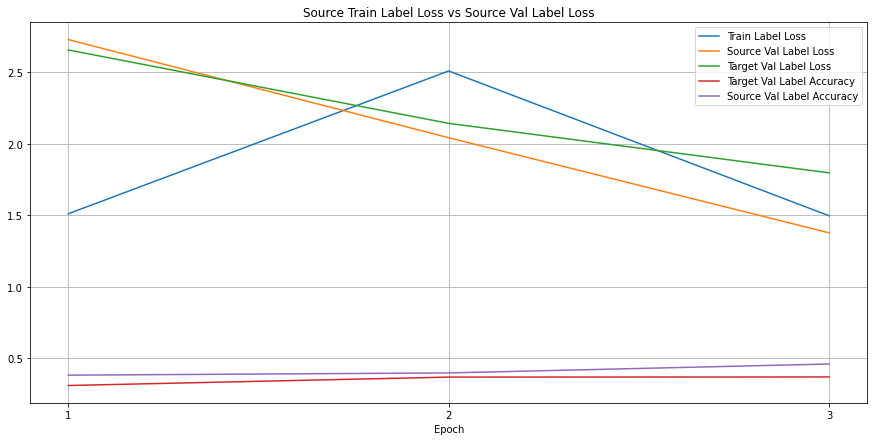

In [14]:
show_jig_diagram(experiment)

<AxesSubplot:title={'center':'Results'}>

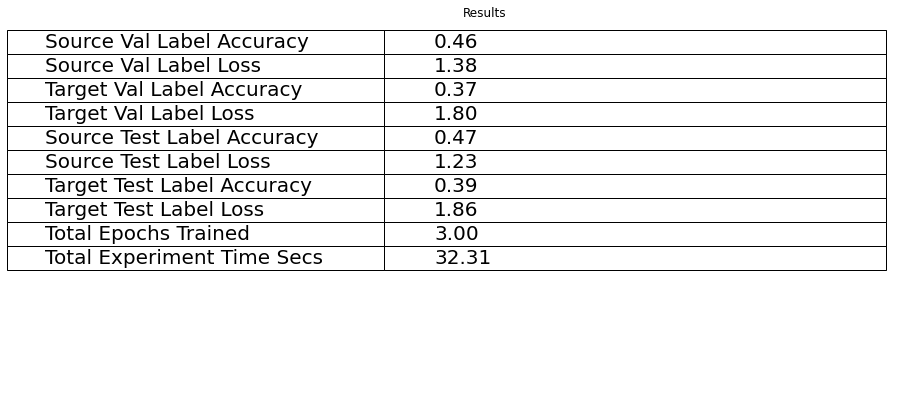

In [15]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Parameters'}>

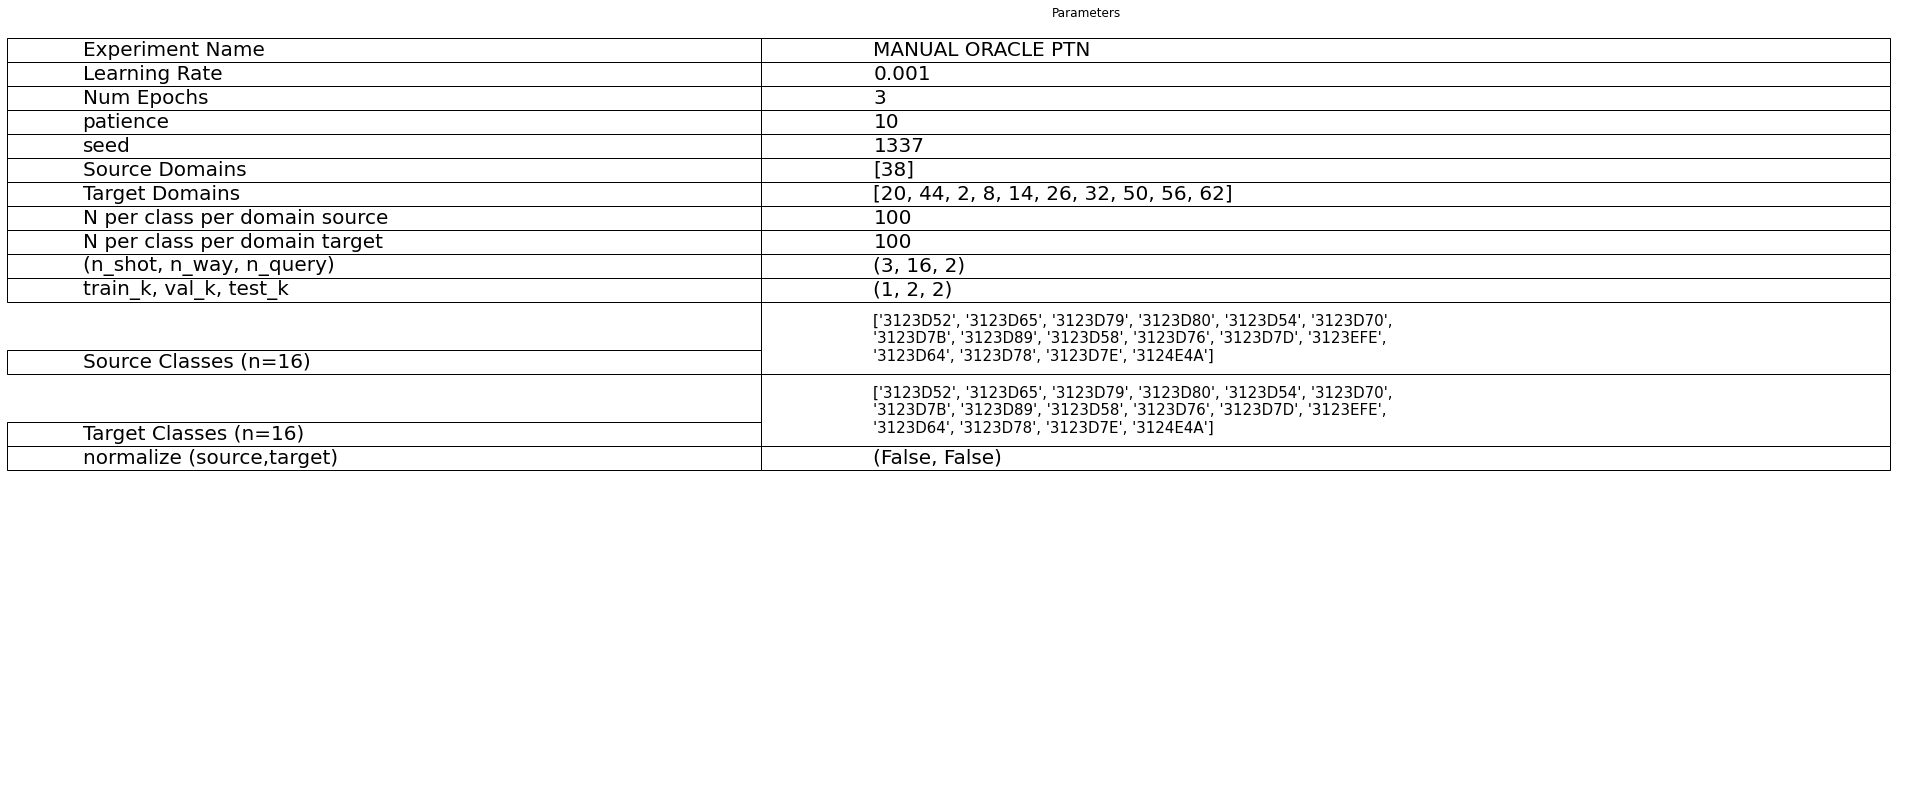

In [16]:
get_parameters_table(experiment)


<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

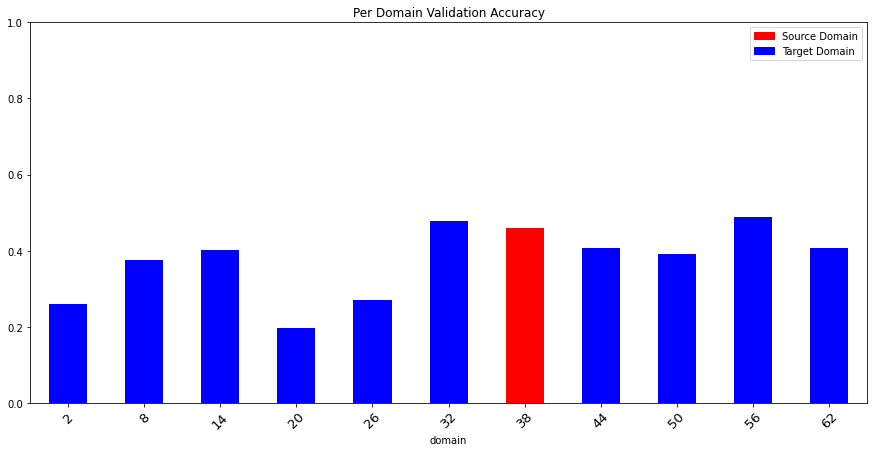

In [17]:
get_domain_accuracies(experiment)

In [18]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.4739583333333333 Target Test Label Accuracy: 0.38645833333333335
Source Val Label Accuracy: 0.4583333333333333 Target Val Label Accuracy: 0.36770833333333336


In [19]:
json.dumps(experiment)

'{"experiment_name": "MANUAL ORACLE PTN", "parameters": {"experiment_name": "MANUAL ORACLE PTN", "lr": 0.001, "device": "cuda", "seed": 1337, "desired_classes_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "desired_classes_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "source_domains": [38], "target_domains": [20, 44, 2, 8, 14, 26, 32, 50, 56, 62], "num_examples_per_class_per_domain_source": 100, "num_examples_per_class_per_domain_target": 100, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 1, "val_k_factor": 2, "test_k_factor": 2, "n_epoch": 3, "patience": 10, "criteria_for_best": "target", "normalize_source": false, "normalize_target": false, "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1